In [1]:
!pip install albumentations
#!pip install efficientnet_pytorch

     |████████████████████████████████| 634kB 18.9MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=397df2f95dde7c5683c0ae22f1394168dcd693d6e4e62459b945847af55e58d4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
#импортируем все что пригодится
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import albumentations
from albumentations import pytorch as AT

#from efficientnet_pytorch import EfficientNet

%matplotlib inline

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/taskonML/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/taskonML/test.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
train_dir = '/content'
test_dir = '/content/test'

In [7]:
train_data = pd.read_csv('/content/drive/MyDrive/taskonML/train_labels.csv')
kl = np.asarray(train_data['sports'].unique())

In [8]:
len(kl)

22

In [9]:
encoder = LabelEncoder()
train_data['num_labels'] = encoder.fit_transform(train_data['sports'])

In [ ]:
list (map(lambda x:x[1:], train_data['image'])) 

In [ ]:
train_files = os.listdir(train_dir + '/train')
train_files = train_data
train_files

In [12]:
class CustomDataset(Dataset):
    def __init__(self, file_csv, dir, transform=None, mode = 'train'):
        self.file_csv = file_csv
        self.dir = dir
        self.transform = transform
        self.mode = mode
            
    def __len__(self):
        return len(self.file_csv)
    
    #метод который позволяет нам индексировать датасет
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_csv['image'][idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        self.label = int(train_data['num_labels'][idx])
        
        #применяем аугментации
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        if self.mode == 'train':
            return image, float(self.label)
        else:
            return image, self.file_csv['image'][idx]

In [13]:
#зададим немного гиперпараметров
batch_size = 32
num_workers = 2
img_size = 256

In [35]:
data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

In [15]:
trainset = CustomDataset(train_files, train_dir, transform = data_transforms)
#test_set = CustomDataset(test_files, test_dir, transform=data_transforms_test, mode = 'test')

In [16]:
train_size = int(0.7 * len(train_files))
valid_size = int(0.15 * len(train_files))
test_size = len(train_files) - train_size - valid_size
train_set, valid_set, test_set = torch.utils.data.random_split(
    trainset, (train_size, valid_size, test_size), generator=torch.Generator().manual_seed(42))

In [ ]:
#Доработать!!!!!
#from sklearn import model_selection, metrics
#train, test = model_selection.train_test_split(
#    train_data, test_size=0.14, random_state=42
#    , stratify=train_files.num_labels.values
#)
#train, validate = model_selection.train_test_split(
#    train, test_size=0.15, random_state=42
#    , stratify=train.num_labels.values
#)
#train_set = CustomDataset(train, train_dir, transform = data_transforms)
#valid_set = CustomDataset(validate, train_dir, transform = data_transforms)
#test_set = CustomDataset(test, train_dir, transform = data_transforms)

In [ ]:
len(train_set), len(valid_set), len(test_set)

(7727, 1656, 1657)

In [17]:
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True, 
                                        num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_set, pin_memory=True, 
                                        batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size,
                                        num_workers = num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([16.,  8., 18.,  2.,  8., 20., 17., 12., 11.,  7.,  0.,  3., 12.,  8.,
        20., 13.,  7., 18., 13., 20.,  8., 19., 12.,  4.,  0.,  4., 13.,  0.,
        20.,  0., 19.,  8.], dtype=torch.float64)


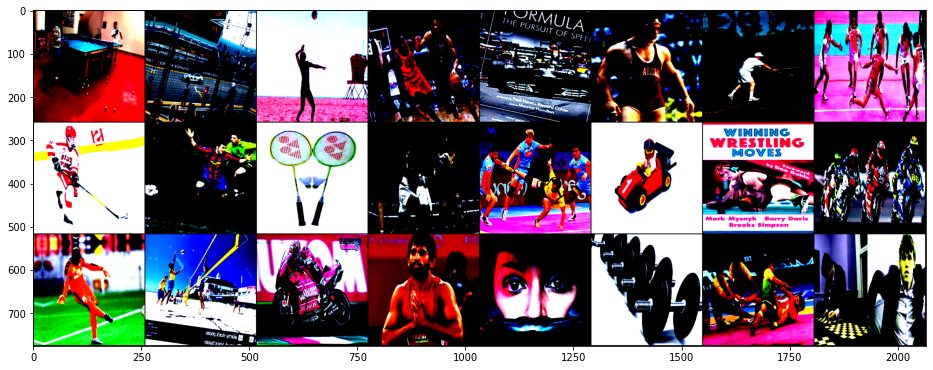

In [ ]:
#Проверим работоспособность
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
#  чтобы вывести изображение, нужно его немного преобразовать из тензора обратно в нампай
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
model = torchvision.models.resnet152(pretrained=True, progress=True)
#заморозим веса, чтобы использовать полностью предобученную сетку
for param in model.parameters():
    param.requires_grad = False

#model

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [20]:
model.fc = nn.Linear(2048, 22)
#model

In [21]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, scheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target.long())
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    # запускаем валидацию
        model_conv.eval()
        correct = 0
        val_loss = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model_conv(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            loss = criterion(output, target.long())
            val_loss.append(loss.item()) 
        
        acc = correct / len(valid_set)

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
        print(f'Accuracy on valid set: {acc}')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            p = 0

        # проверяем как дела на валидации
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv, train_loss, val_loss

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,)

In [23]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler, n_epochs=30,)

Mon Apr 26 09:50:33 2021 Epoch: 1
Epoch 1, train loss: 1.2653, valid loss: 0.6366.
Accuracy on valid set: 0.841183574879227
Validation loss decreased (inf --> 0.636593).  Saving model ...
Mon Apr 26 09:52:22 2021 Epoch: 2
Epoch 2, train loss: 0.6159, valid loss: 0.5346.
Accuracy on valid set: 0.8472222222222222
Validation loss decreased (0.636593 --> 0.534561).  Saving model ...
Mon Apr 26 09:54:08 2021 Epoch: 3
Epoch 3, train loss: 0.5164, valid loss: 0.4914.
Accuracy on valid set: 0.8586956521739131
Validation loss decreased (0.534561 --> 0.491438).  Saving model ...
Mon Apr 26 09:55:54 2021 Epoch: 4
Epoch 4, train loss: 0.4588, valid loss: 0.4572.
Accuracy on valid set: 0.8592995169082126
Validation loss decreased (0.491438 --> 0.457212).  Saving model ...
Mon Apr 26 09:57:40 2021 Epoch: 5
Epoch 5, train loss: 0.4188, valid loss: 0.4855.
Accuracy on valid set: 0.8454106280193237
1 epochs of increasing val loss
Mon Apr 26 09:59:25 2021 Epoch: 6
Epoch 6, train loss: 0.3972, valid loss

In [24]:
#загрузим лучшую модель и проведем на ней инференс (прогон тестовых данных)
model.state_dict(torch.load('/content/model.pt'))
print(1)

1


In [25]:
model.eval()
correct = 0

with torch.no_grad():
  for data, target in testloader:
    data = data.to(device=device)
    target = target.to(device=device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum().item()


acc = correct / len(test_set)
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.8744719372359686


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([18., 18.,  1., 10., 15., 14., 19.,  8.,  3., 21.,  2.,  5.,  6.,  2.,
        11., 14.,  0.,  2.,  7.,  1., 18.,  4., 18.,  8., 15., 12., 17.,  2.,
        21., 15.,  4.,  8.], dtype=torch.float64)


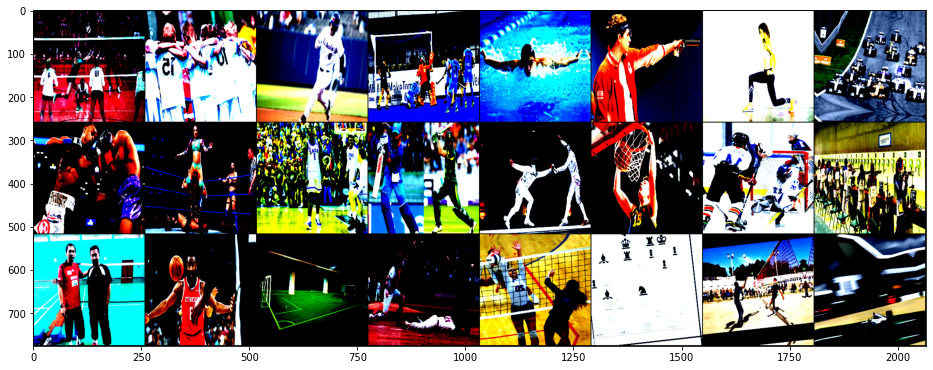

In [26]:
#Проверим работоспособность
samples, labels = next(iter(testloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
#  чтобы вывести изображение, нужно его немного преобразовать из тензора обратно в нампай
print(labels)
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [36]:
from pathlib import Path

model.to(device)
model.eval()
df_preds = pd.DataFrame()
for path in Path('/content/ttest').iterdir():
    img = cv2.imread(str(path))[:, ::-1]
    img = data_transforms_test(image=img)['image'].cuda()
    pred = model(img[None])
    
    df_preds = df_preds.append(
        {'image': path.absolute(), 'labels': encoder.inverse_transform(torch.argmax(pred.cpu(), dim=1))[0]},
        ignore_index=True)
    
df_preds

,image,labels
0,/content/ttest/7.jpg,basketball
1,/content/ttest/4.jpg,ice_hockey
2,/content/ttest/2.jpg,boxing
3,/content/ttest/6.jpg,volleyball
4,/content/ttest/3.jpg,motogp
5,/content/ttest/1.jpg,football
6,/content/ttest/5.jpg,swimming


In [ ]:
df_preds.to_csv('/content/submission.csv', index = False)

In [28]:
with zipfile.ZipFile('/content/drive/MyDrive/taskonML/ttest.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

with zipfile.ZipFile('/content/drive/MyDrive/taskonML/model.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [31]:
weight = '/content/model.pt'
path_to_dataset = '/content/ttest'

In [32]:
def infer(weight, path_to_dataset):
  from pathlib import Path
  from sklearn.preprocessing import LabelEncoder

  img_size = 256

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = torchvision.models.resnet152(pretrained=True, progress=True)
  model.fc = nn.Linear(2048, 22)

  model.load_state_dict(torch.load(weight))

  #train_data = pd.read_csv('/content/drive/MyDrive/taskonML/train_labels.csv')
  #encoder = LabelEncoder()
  #train_data['num_labels'] = encoder.fit_transform(train_data['sports'])

  labels_class = ['badminton',
                  'baseball',
                  'basketball',
                  'boxing',
                  'chess',
                  'cricket',
                  'fencing',
                  'football',
                  'formula1',
                  'gymnastics',
                  'hockey',
                  'ice_hockey',
                  'kabaddi',
                  'motogp',
                  'shooting',
                  'swimming',
                  'table_tennis',
                  'tennis',
                  'volleyball',
                  'weight_lifting',
                  'wrestling',
                  'wwe']

  data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    AT.ToTensor()
    ]) 
  
  model.to(device)
  model.eval()
  df_preds = pd.DataFrame()
  for path in Path(path_to_dataset).iterdir():
    img = cv2.imread(str(path))[:, ::-1]
    img = data_transforms(image=img)['image'].cuda()
    pred = model(img[None])
    
    df_preds = df_preds.append(
        {'image': path.absolute(), 'labels': labels_class[torch.argmax(pred.cpu(), dim=1)]},
        ignore_index=True)
  df_preds.to_csv('/content/submission.csv', index = False)

In [33]:
infer(weight, path_to_dataset)